# ATMS 523 Module 2 Homework
##### B. Engelsen 9/17/22

#### References


##### - THREDDS ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)
###### ds633.0 | DOI: 10.5065/BH6N-5N20

##### - AWS ERA5 data Generated from Copernicus Climat Change Service
###### Amazon Resource Name (ARN):aws:s3:::era5-pds
###### URL: http://era5-pds.s3.amazonaws.com/

### A . Read in Packages

In [2]:
import seaborn as sb
import xarray as xr
import numpy as np
from glob import glob as gg
import os
import urllib.request # module for downloading data from URLs
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs 
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
import datetime as dt
import chardet
from pandas.tseries.offsets import MonthEnd
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from netCDF4 import Dataset
import h5py

### B. Set up local cluster on laptop

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56904,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.39 GiB
Comm: tcp://127.0.0.1:56942,Total threads: 2
Dashboard: http://127.0.0.1:56943/status,Memory: 3.85 GiB
Nanny: tcp://127.0.0.1:56908,


### (Question: 1) Using output from the ERA-5 reanalysis available from the NCAR Research Data Archive, use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing.

### D. Read in data from AWS

In [8]:
# Make garbage collection explicit to prevent deadlocks
import gc
from distributed import WorkerPlugin

class WorkerExplicitGC(WorkerPlugin):
    def setup(self, worker):
        self.worker = worker
        gc.disable()             

    def transition(self, key, start, finish, *args, **kwargs):
       if finish == 'executing':
          self.worker._throttled_gc.collect()
          if gc.isenabled():
             gc.disable()

plugin = WorkerExplicitGC()
client.register_worker_plugin(plugin)

{'tcp://127.0.0.1:52836': {'status': 'OK'},
 'tcp://127.0.0.1:52839': {'status': 'OK'},
 'tcp://127.0.0.1:52840': {'status': 'OK'},
 'tcp://127.0.0.1:52846': {'status': 'OK'}}

In [9]:
def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})
    return s3fs.S3Map(path, s3=fs)


def open_era5_range(start_year, end_year, variables):
    ''' Opens ERA5 monthly Zarr files in S3, given a start and end year (all months loaded) and a list of variables'''
    
    
    file_pattern = 'era5-pds/zarr/{year}/{month}/data/{var}.zarr/'
    
    years = list(np.arange(start_year, end_year+1, 1))
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    l = []
    for var in variables:
        print(var)
        
        # Get files
        files_mapper = [s3open(file_pattern.format(year=year, month=month, var=var)) for year in years for month in months]
        
        # Look up correct time dimension by variable name
        if var in ['precipitation_amount_1hour_Accumulation']:
            concat_dim='time1'
        else:
            concat_dim='time0'
            
        # Lazy load
        ds = xr.open_mfdataset(files_mapper, engine='zarr', 
                               concat_dim=concat_dim, combine='nested', 
                               coords='minimal', compat='override', parallel=True)
        
        # Fix dimension names
        ds = fix_accum_var_dims(ds, var)
        l.append(ds)
        
    ds_out = xr.merge(l)
    
    return ds_out

In [10]:
ds = open_era5_range(1979, 2021, ["precipitation_amount_1hour_Accumulation"])

precipitation_amount_1hour_Accumulation


In [11]:
# Do the slicing and take the mean over Rockton, IL
# https://www.google.com/search?q=rockton+illinois+latitude+and+longitude&rlz=1C1GCEB_enUS1006US1006&oq=rockton+illinois+latitude+and+long&aqs=chrome.1.69i57j33i160l2.9337j0j7&sourceid=chrome&ie=UTF-8
lat_rock = 42.45 #42.4525° N
lon_rock = 89.07 #89.0723° W

In [12]:
#Daily data near Rockton, IL
rock_day = ds["precipitation_amount_1hour_Accumulation"].sel(lat=lat_rock,lon=360.-lon_rock,method='nearest').resample(valid_time_end_utc="1D").sum().compute()
#Monthly data near Rockton, IL
rock_month = rock_day.groupby('valid_time_end_utc.month').mean()

c:\ProgramData\Anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
c:\ProgramData\Anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [13]:
rock_day.to_netcdf('rock_day.nc')

In [14]:
#Index hourly data for 2021 time series of precipitation
rock_day_2021 = rock_day.sel(valid_time_end_utc=slice('2021-1-1','2021-12-31'))

### Plot Time Series

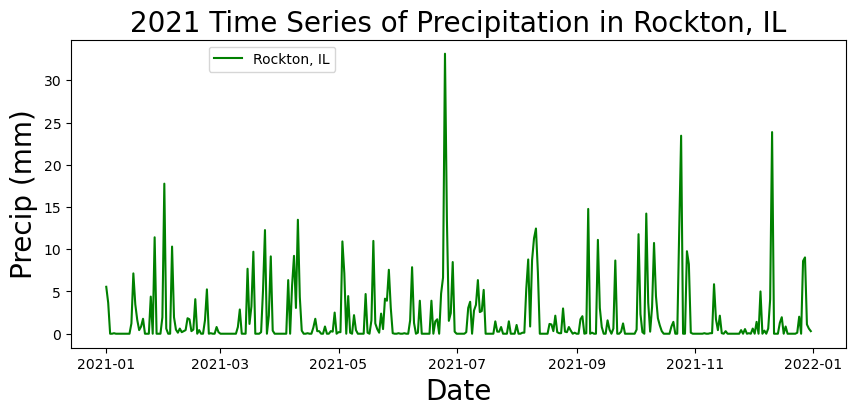

In [15]:
# Plot time series of precipitation in Rockton, IL in 2021
plt.figure(figsize=(10,4))
ax = plt.gca()
# ax.xaxis.set_major_formatter(hfmt)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Precip (mm)', fontsize=20)
plt.title('2021 Time Series of Precipitation in Rockton, IL', fontsize=20)
plt.plot(rock_day_2021.valid_time_end_utc,rock_day_2021*1000,color="green",label="Rockton, IL")
plt.legend(bbox_to_anchor=(.35, 1.0), loc=1)

### (Question: 2) Determine the 95% values of daily precipitation during a selected particular 3-month period of time associated with the wettest 3 months of the year closest to your city (use the data to tell you this).  Plot a *cumulative distribution function* of all values daily precipitation values during this time and illustrate the 95% value of daily precipitation in millimeters.

In [16]:
#Finding the 3 wettests months using .sortby
wet3 = rock_month.month.sortby(rock_month, ascending=False)
print(wet3.month.values[0:3])

[4 6 5]


In [17]:
# Select the three wettest months using values above
precip_AMJ_day = rock_day.where((rock_day.valid_time_end_utc.dt.month >= 4) & (rock_day.valid_time_end_utc.dt.month <= 6), drop=True)

In [18]:
precip_AMJ_day

<xarray.DataArray 'precipitation_amount_1hour_Accumulation' (valid_time_end_utc: 3913)>
array([0.00012207, 0.01293945, 0.        , ..., 0.00244141, 0.00848389,
       0.00024414], dtype=float32)
Coordinates:
  * valid_time_end_utc  (valid_time_end_utc) datetime64[ns] 1979-04-01 ... 20...
    lat                 float32 42.5
    lon                 float32 271.0

### Plot CDF with 95 percentile

Text(0, 0.5, 'Fraction of Data')

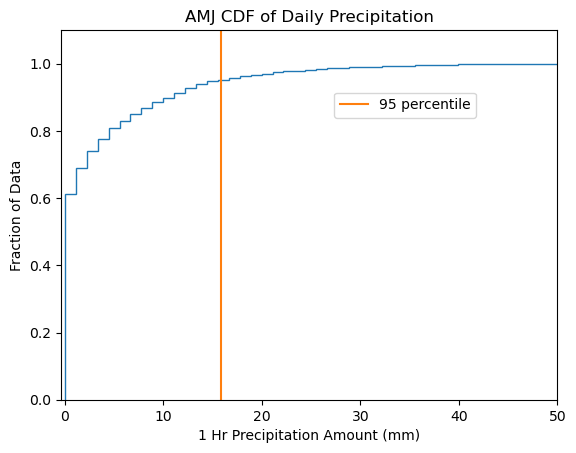

In [20]:
#Create CDF with 95 percentile

quant95_AMJ = precip_AMJ_day.quantile(.95)*1000

bins = 50
ax = (precip_AMJ_day*1000).plot.hist(bins=bins, density=True, histtype='step',
                                     cumulative=True, xticks=None, yticks=None, xlim=[-0.35,50], ylim=[0,1.1])
plt.plot([quant95_AMJ,quant95_AMJ],[0,2], label='95 percentile')
plt.legend(bbox_to_anchor=(.85, 0.85), loc=1)
plt.title("AMJ CDF of Daily Precipitation")
plt.xlabel("1 Hr Precipitation Amount (mm)")
plt.ylabel("Fraction of Data")

### (Question: 3) Create a map of the composite mean precipitation on days with precipitation meeting the 95% threshold, and the anomaly of precipitation from the 1981-2010 seasonal (i.e., the 3 months you have chosen) mean. This field should be plotted on a cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [21]:
#Daily Precip data 40x40 deg range centered on Rockton, IL Resampled and summed over 1 day
# lat_rock = 42.45 #42.4525° N
# lon_rock = 89.07 #89.0723° W

rock_day_spatial = ds["precipitation_amount_1hour_Accumulation"].sel(lat=slice(lat_rock+20,lat_rock-20,1),
                                                                     lon=slice((360.-lon_rock)-20,(360.-lon_rock)+20,1)).resample(valid_time_end_utc="1D").sum().compute()

2022-09-19 21:15:45,841 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:52839 (pid=23780) exceeded 95% memory budget. Restarting...
2022-09-19 21:16:03,298 - distributed.nanny - WARNING - Restarting worker


In [22]:
#output sliced data
rock_day_spatial.to_netcdf('rock_day_spatial.nc')

In [23]:
#Index where greater than 95%
precip_day_ext = rock_day_spatial.where(rock_day_spatial >= precip_AMJ_day.quantile(.95), drop=True)

In [25]:
# Take temporal average over all extreme precip days (> 95 percentile)
precip_day_ext_comp = precip_day_ext.sel(valid_time_end_utc=slice('1981-1-1', '2010-12-31')).mean(dim='valid_time_end_utc')

In [1]:
precip_AMJ_mean = precip_AMJ_day.sel(valid_time_end_utc=slice('1981-1-1','2010-12-31')).mean()

In [26]:
# subtract extreme values from mean
anomaly = precip_day_ext_comp-precip_AMJ_mean

### Plot precip_day_ext_comp

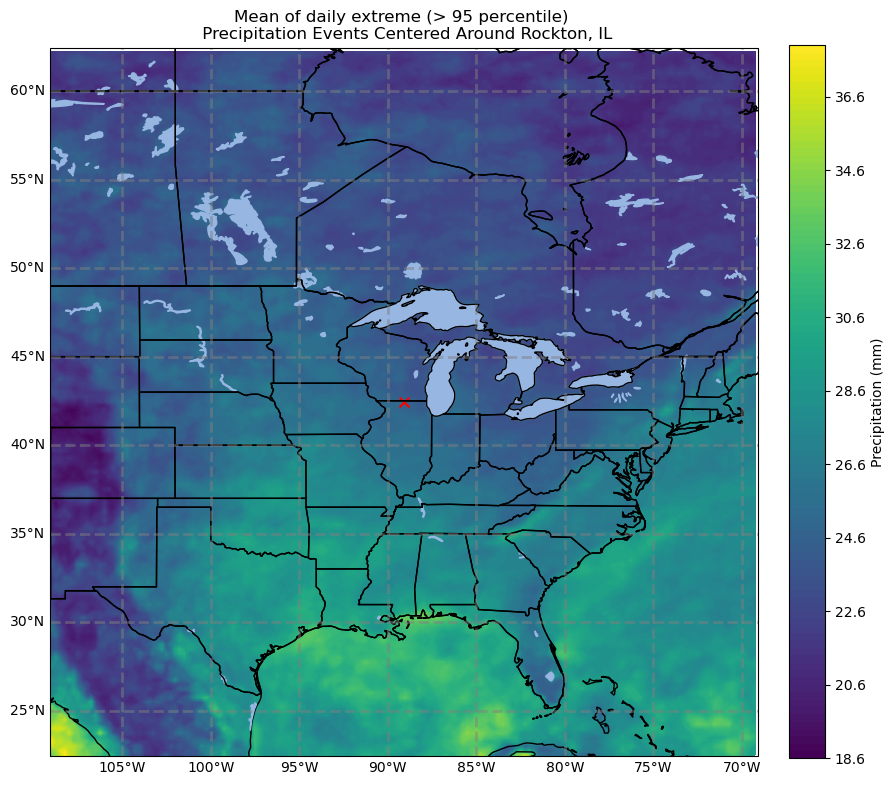

In [27]:
#plot mean of extreme precip events centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = ax.contourf(precip_day_ext_comp.lon,precip_day_ext_comp.lat,precip_day_ext_comp*1000, 100, 
                    cmap='viridis', transform=ccrs.PlateCarree())

image2 = ax.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('Mean of daily extreme (> 95 percentile) \n Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Precipitation (mm)')

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)


### Plot anomaly

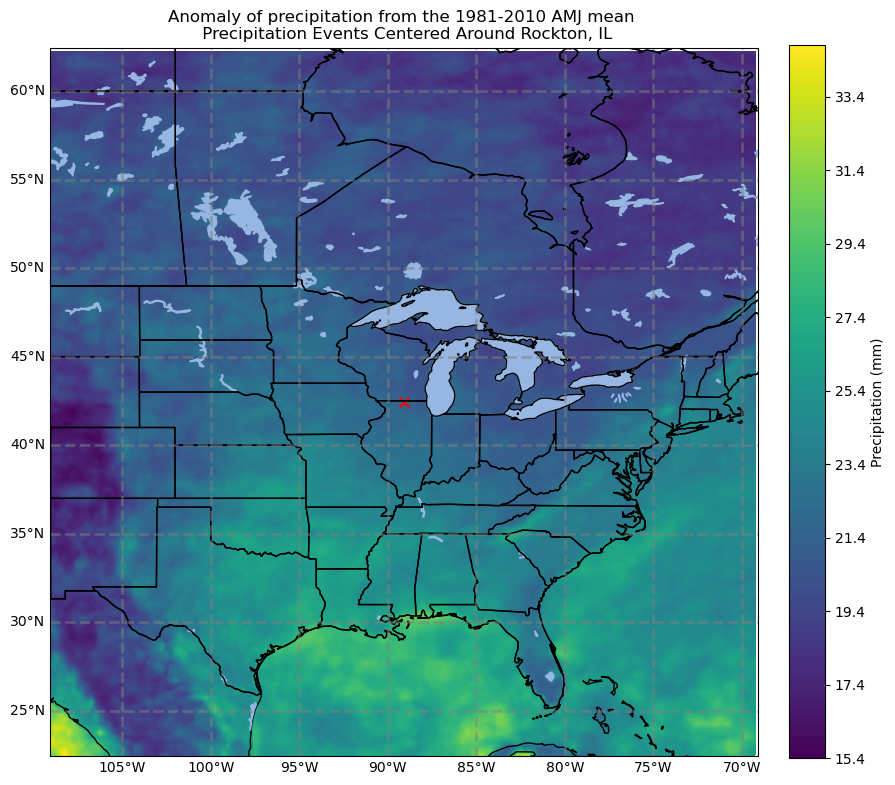

In [28]:
# Plot 1981-2010 anomaly of precip centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(anomaly.lon,anomaly.lat,anomaly*1000, 100, 
                    cmap='viridis', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('Precipitation Anomaly from the 1981-2010 AMJ mean \n Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Precipitation (mm)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)


In [29]:
precip_day_ext_comp.close()
anomaly.close()
rock_day_spatial.close()
rock_day.close()
rock_month.close()
ds.close()

### (Question: 4) Using output from the ERA-5 reanalysis available from the NCAR Research Data Archive, compute the global mean fields (use the 12 UTC time for your averages) on days meeting and exceeding the threshold of precipitation calculated in the previous steps of 
- 250 hPa wind speed (contoured) (calculate from u and v wind as a pressure level quantity)
- 850 hPa specific humidity (contoured) (pressure level quantity)
- total atmospheric column water vapor (contoured) (atmospheric integral quantity)
These should be plotted on a `cartopy` map showing a geographic region centered at your city with a 40 x 40 degree lat-lon range.

### D. Read in data from Thredds data server. Doi in markdown above

In [7]:
lat_rock = 42.45 #42.4525° N
lon_rock = 89.07 #89.0723° W

base_url_u = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1/e5.oper.an.pl/' #wind = 128_131/u
base_url_v = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1/e5.oper.an.pl/' #wind = 128_132/v
base_url_q = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1/e5.oper.an.pl/' #specific humidity = 128_133/q
base_url_tcwv = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1/e5.oper.an.sfc/' #total column water vapor = 128_137/tcwv
# base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/' #precip = e5.moda.fc.sfc.accumu/128_228/tp
base_url2_u = '/e5.oper.an.pl.128_131_u.ll025uv.' #wind = 128_131/u
base_url2_v = '/e5.oper.an.pl.128_132_v.ll025uv.' #wind = 128_132/v
base_url2_q = '/e5.oper.an.pl.128_133_q.ll025sc.' #specific humidity = 128_133/q
base_url2_tcwv = '/e5.oper.an.sfc.128_137_tcwv.ll025sc.' #total column water vapor = 128_137/tcwv
# base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.' #precip = e5.moda.fc.sfc.accumu/128_228/tp
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_u=[]
file_list_v=[]
file_list_q=[]
file_list_tcwv=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    # month = (dt + pd.DateOffset(days=11)).strftime('%Y%m%d%H')
    # month2 = (dt + pd.DateOffset(days=int(pr.days_in_month[0]-1),hours=23)).strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name for u
    single_file_u=(base_url_u+year+base_url2_u+month+'_'+month2+base_url3)
    file_list_u.append(single_file_u)

    # build complete file name for v
    single_file_v=(base_url_u+year+base_url2_v+month+'_'+month2+base_url3)
    file_list_v.append(single_file_v)

    # build complete file name for q
    single_file_q=(base_url_q+year+base_url2_q+month+'_'+month2+base_url3)
    file_list_q.append(single_file_q)

    # build complete file name for tcwv
    single_file_tcwv=(base_url_tcwv+year+base_url2_tcwv+month+'_'+month2+base_url3)
    file_list_tcwv.append(single_file_tcwv)


In [8]:
file_list_u[0]

'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1/e5.oper.an.pl/1979/e5.oper.an.pl.128_131_u.ll025uv.1979010100_1979120100.nc'

In [ ]:
# check = xr.open_dataset(file_list_v[0], chunks={"time": 10}).sel(level = 250.0).sel(latitude=slice(lat_rock+20,lat_rock-20,1),longitude=slice((360.-lon_rock)-20,(360.-lon_rock)+20,1)).compute()

In [ ]:
# check

In [ ]:
# xr.set_options(file_cache_maxsize=128)

In [1]:
ds_u = xr.open_mfdataset(file_list_u, parallel=True, chunks={'time': '50MB'}).sel(level = 250.0).sel(latitude=slice(lat_rock+20,lat_rock-20,1),longitude=slice((360.-lon_rock)-20,(360.-lon_rock)+20,1))
ds_v = xr.open_mfdataset(file_list_v, parallel=True, chunks={'time': '5MB'}).sel(level = 250.0).sel(latitude=slice(lat_rock+20,lat_rock-20,1),longitude=slice((360.-lon_rock)-20,(360.-lon_rock)+20,1))
ds_q = xr.open_mfdataset(file_list_q, parallel=True, chunks={'time': '5MB'}).sel(level = 850.0).sel(latitude=slice(lat_rock+20,lat_rock-20,1),longitude=slice((360.-lon_rock)-20,(360.-lon_rock)+20,1))
ds_tcwv = xr.open_mfdataset(file_list_tcwv, parallel=True, chunks={'time': '5MB'}).sel(latitude=slice(lat_rock+20,lat_rock-20,1),longitude=slice((360.-lon_rock)-20,(360.-lon_rock)+20,1))

In [ ]:
# Resample to daily averages

ds_u = ds_u.resample(time='1D').mean(dim='time')
ds_v = ds_v.resample(time='1D').mean(dim='time')
ds_q = ds_q.resample(time='1D').mean(dim='time')
ds_tcwv = ds_tcwv.resample(time='1D').mean(dim='time')

In [ ]:
# Output netCDF files

# ds_u.to_netcdf('ds_u.nc')
# ds_v.to_netcdf('ds_v.nc')
# ds_q.to_netcdf('ds_q.nc')
# ds_tcwv.to_netcdf('ds_tcwv.nc')

In [ ]:
# Select where precip daily totals are greater than 95 percentile

ds_u_250_ext = ds_u.sel(time = precip_day_ext.valid_time_end_utc)
ds_v_250_ext = ds_v.sel(time = precip_day_ext.valid_time_end_utc)
ds_q_850_ext = ds_q.sel(time = precip_day_ext.valid_time_end_utc)
ds_tcwv_col_ext = ds_tcwv.sel(time = precip_day_ext.valid_time_end_utc)

In [ ]:
# Take temporal average over all extreme precip days (> 95 percentile)
ds_u_mean1981_2010 = ds_u_250_ext.sel(time=slice('1981-1-1', '2010-12-31')).mean(dim='time')
ds_v_mean1981_2010 = ds_v_250_ext.sel(time=slice('1981-1-1', '2010-12-31')).mean(dim='time')
ds_q_mean1981_2010 = ds_q_850_ext.sel(time=slice('1981-1-1', '2010-12-31')).mean(dim='time')
ds_tcwv_mean1981_2010 = ds_tcwv_col_ext.sel(time=slice('1981-1-1', '2010-12-31')).mean(dim='time')

In [ ]:
# #Calculate WS
WS_250_ext = np.sqrt(np.square(ds_u_250) + np.square(ds_v_250))

WS_250_1981_2010 = np.sqrt(np.square(ds_u_mean1981_2010) + np.square(ds_v_mean1981_2010))

In [ ]:
# subtract extreme values from mean
anomaly_wind = WS_250_ext-WS_250_1981_2010
anomaly_q = ds_q_850_ext-ds_q_mean1981_2010
anomaly_tcwv = ds_tcwv_col_ext-ds_tcwv_mean1981_2010

### Plot WS_250

In [ ]:
#plot composite mean of 250 mb winds for extreme precip events centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(WS_250_ext.longitude,WS_250_ext.latitude,WS_250_ext, 100, 
                    cmap='bwr', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('250 mb Wind Speed Composite Mean for \n Extreme Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Wind Speed (m/s)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)

###  Plot ds_q_850

In [ ]:
#plot composite mean of 850 mb specific humidity for extreme precip events centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(ds_q_850_ext.longitude,ds_q_850_ext.latitude,ds_q_850_ext, 100, 
                    cmap='BrBG', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('850 mb Specific Humidity Composite Mean for \n Extreme Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Specific Humidity (kg/kg)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)

### Plot ds_tcwv_col

In [ ]:
#plot composite mean of total column water vapor for extreme precip events centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(ds_tcwv_col_ext.longitude,ds_tcwv_col_ext.latitude,ds_tcwv_col_ext, 100, 
                    cmap='BrBG', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('Total Column Water Vapor Composite Mean for \n Extreme Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Total Column Water Vapor (kg*m^-2)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)


### (Question: 5) Compute the anomalies from the 3 month period for the fields identified in (4).

In [ ]:
# subtract extreme values from mean
anomaly_wind = WS_250_ext-WS_250_1981_2010
anomaly_q = ds_q_850_ext-ds_q_mean1981_2010
anomaly_tcwv = ds_tcwv_col_ext-ds_tcwv_mean1981_2010

### Plot anomaly_wind

In [ ]:
#plot 1981-2010 anomaly of precip centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(anomaly_wind.longitude,anomaly_wind.latitude,anomaly_wind, 100, 
                    cmap='bwr', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('250 mb Wind Speed Anomaly from the 1981-2010 AMJ mean \n Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Wind Speed (m/s)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)


### Plot anomaly_q

In [ ]:
#plot 1981-2010 anomaly of precip centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(anomaly_q.longitude,anomaly_q.latitude,anomaly_q, 100, 
                    cmap='BrBG', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('850 mb Specific Humidity Anomaly from the 1981-2010 AMJ mean \n Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Specific Humidity (kg/kg)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)


### Plot anomaly_tcwv

In [ ]:
#plot 1981-2010 anomaly of precip centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(anomaly_tcwv.longitude,anomaly_tcwv.latitude,anomaly_tcwv, 100, 
                    cmap='BrBG', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('Total Column Water Vapor Anomaly from the 1981-2010 AMJ mean \n Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Total Column Water Vapor (kg*m^-2)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)

### Close client to free up RAM

In [5]:
client.close()